In [2]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

In [3]:
from pyldl.utils import encode_one_hot, kullback_leibler_divergence
from pyldl.layers import AutoEncoder, Sequential
from pyldl.modules import Linear
from pyldl.losses import BCELoss, MSELoss
from pyldl.activations import Sigmoid, Tanh
from pyldl.optimizers import SGD

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np

In [4]:
np.random.seed(0)

In [5]:
def add_noise(data, sigma=0.05):
    return data + sigma*np.random.randn(*data.shape) 

In [6]:
digits = load_digits()

X = digits.data

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_noise = add_noise(X)
X_train, X_test, y_train, y_test = train_test_split(X_noise, X, test_size=0.2)

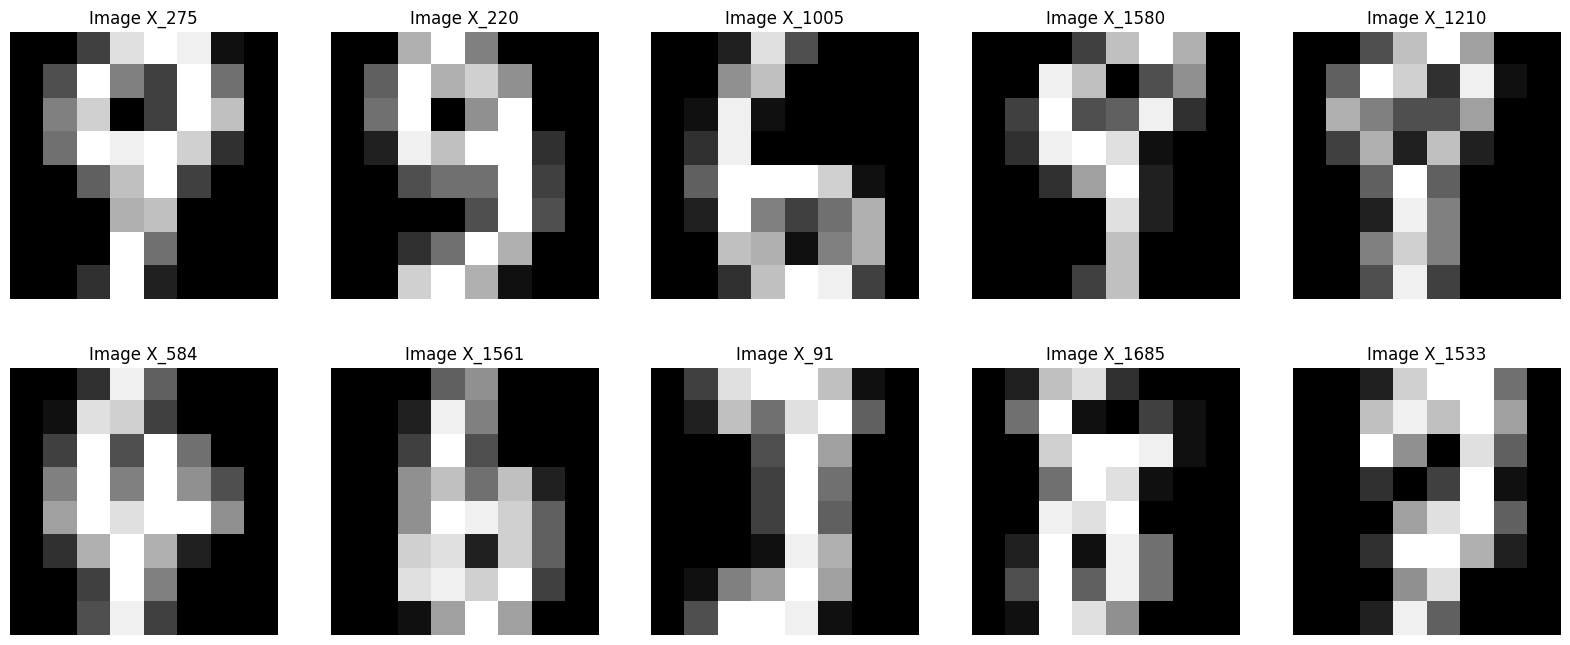

In [7]:
n_images = 10
random_indexes = np.random.choice(range(len(X)), n_images)
images = X[random_indexes]

plt.subplots(2, 5, figsize=(20, 8))
for i in range(n_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Image X_{random_indexes[i]}")
    plt.axis('off')
plt.show()

In [8]:
encoder = Sequential(
    Linear(X_train.shape[1], 32), 
    Tanh(),
    Linear(32, 16),
    Tanh(),
    Linear(16, 2),
    Tanh(),
)

decoder = Sequential(
    Linear(2, 16),
    Tanh(),
    Linear(16, 32),
    Tanh(),
    Linear(32, X_train.shape[1]),
    Sigmoid()
)

autoencoder = AutoEncoder(encoder, decoder)

In [9]:
losses = SGD(autoencoder, MSELoss(), X_train, y_train, batch_size=32, gradient_step=1e-3, n_iter=1000)

100%|██████████| 1000/1000 [00:23<00:00, 42.54it/s]


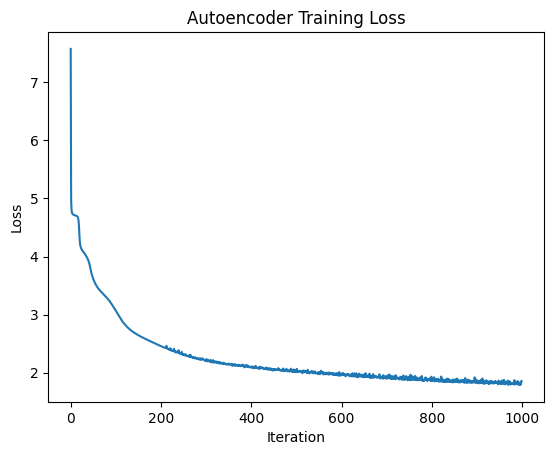

In [10]:
plt.plot(losses)
plt.title("Autoencoder Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [11]:
yhat = autoencoder(X_test)
print("Score: ", kullback_leibler_divergence(yhat, y_test))

Score:  32.657644985682985


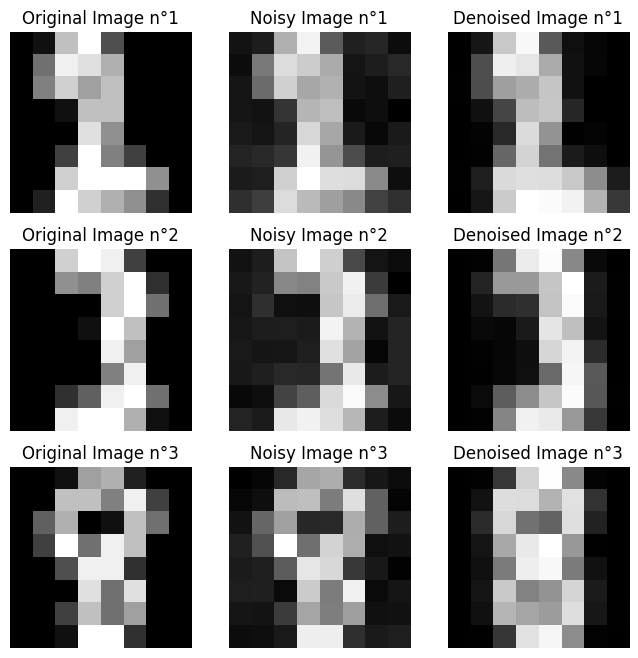

In [12]:
n_images = 3

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = y_test[random_indexes]
noisy_images = X_test[random_indexes]
denoised_images = autoencoder(noisy_images)

plt.subplots(3, 3, figsize=(8, 8))
for i in range(n_images):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(original_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Original Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 3, 3*i+2)
    plt.imshow(noisy_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Noisy Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 3, 3*i+3)
    plt.imshow(denoised_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Denoised Image n°{i+1}")
    plt.axis('off')
plt.show()

## Network Optimization

In [13]:
from itertools import product

def grid_search(X_train, X_test, y_train, y_test, params):
    best_score = np.inf
    best_model = None
    best_params = None
    best_losses = None
    for activation, batch_size, gradient_step, loss, n_epochs, n_neurons_per_layer in product(*params.values()):
        encoder_layers, decoder_layers = [], []
        for i in range(len(n_neurons_per_layer)-1):
            encoder_layers += [Linear(n_neurons_per_layer[i], n_neurons_per_layer[i+1]), activation()]
            decoder_layers = [Linear(n_neurons_per_layer[i+1], n_neurons_per_layer[i]), activation()] + decoder_layers
        autoencoder = AutoEncoder(Sequential(*encoder_layers), Sequential(*decoder_layers))
        losses = SGD(autoencoder, loss(), X_train, y_train, batch_size=batch_size, gradient_step=gradient_step, n_iter=n_epochs)
        reconstructed_images = autoencoder(X_test)
        score = np.abs(kullback_leibler_divergence(y_test, reconstructed_images))
        if score < best_score:
            best_model = autoencoder
            best_score = score
            best_losses = losses
            best_params = {
                "activation_functions": activation.__class__.__name__,
                "batch_size": batch_size,
                "gradient_step": gradient_step,
                "loss": loss.__class__.__name__,
                "n_epochs": n_epochs,
                "n_neurons_per_layer": n_neurons_per_layer,
            }
    return best_model, best_params, best_score, best_losses

In [14]:
# params = {
#     "activation_functions": [Sigmoid, Tanh],
#     "batch_size": [32, 64, 128],
#     "gradient_step": [0.01, 0.001, 0.0001],
#     "loss": [BCELoss, MSELoss],
#     "n_epochs": [500, 1000, 2000],
#     "n_neurons_per_layer": [[X_noise.shape[1], 64], [X_noise.shape[1], 64, 32], [X_noise.shape[1], 64, 32, 16]],
# }

params = {
    "activation_functions": [Tanh],
    "batch_size": [32],
    "gradient_step": [0.001],
    "loss": [MSELoss],
    "n_epochs": [1000],
    "n_neurons_per_layer": [[X_train.shape[1], 32, 16, 2]],
}

best_model, best_params, best_score, best_losses = grid_search(X_train, X_test, y_train, y_test, params)

100%|██████████| 1000/1000 [00:29<00:00, 34.44it/s]


In [18]:
print("Best parameters: ", best_params)

Best parameters:  {'activation_functions': 'ABCMeta', 'batch_size': 32, 'gradient_step': 0.001, 'loss': 'ABCMeta', 'n_epochs': 1000, 'n_neurons_per_layer': [64, 32, 16, 2]}


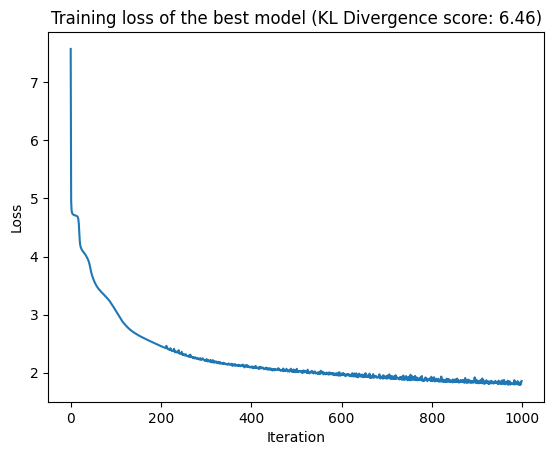

In [19]:
plt.plot(losses)
plt.title(f"Training loss of the best model (KL Divergence score: {best_score:.2f})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

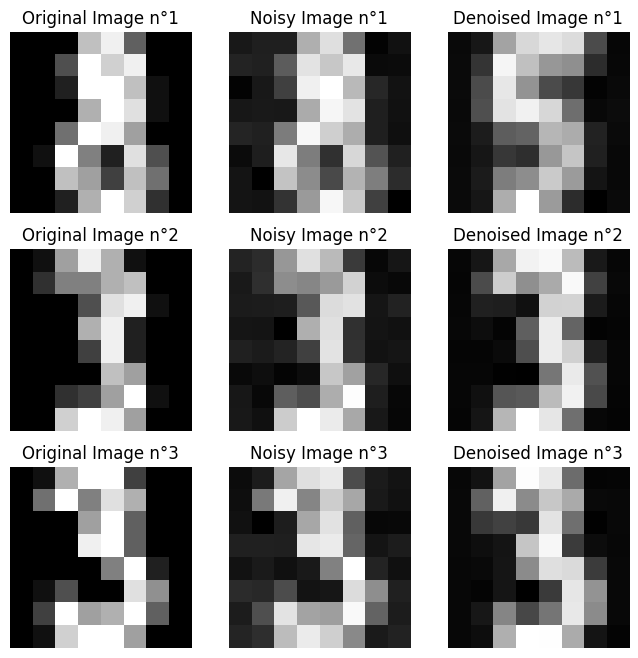

In [17]:
n_images = 3

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = y_test[random_indexes]
noisy_images = X_test[random_indexes]
denoised_images = best_model(noisy_images)

plt.subplots(3, 3, figsize=(8, 8))
for i in range(n_images):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(original_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Original Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 3, 3*i+2)
    plt.imshow(noisy_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Noisy Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 3, 3*i+3)
    plt.imshow(denoised_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Denoised Image n°{i+1}")
    plt.axis('off')
plt.show()